# import packages

In [1]:
import tensorflow as tf
import tensorflow.keras.layers as tkl
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from keras.regularizers import l2
from tensorflow.keras.layers.experimental.preprocessing import RandomZoom, CenterCrop, RandomContrast
from tensorflow.keras.metrics import AUC
import numpy as np
import sklearn.metrics
import tensorflow.keras.backend as kbe

from keras import backend as K
import glob
from PIL import Image
import cv2

**run only once**

In [12]:
#!unzip  "/content/drive/MyDrive/AI/fashion.zip" -d "/content/drive/MyDrive/AI/"

In [2]:
BATCH_SIZE = 128
IMG_SIZE = (32, 32)
training_directory = "../Datasets/work/fashion/train"
valid_directory = "../Datasets/work/fashion/valid"

train_dataset = image_dataset_from_directory(training_directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             seed=42)
validation_dataset = image_dataset_from_directory(valid_directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             seed=42)

Found 19980 files belonging to 2 classes.
Found 830 files belonging to 2 classes.


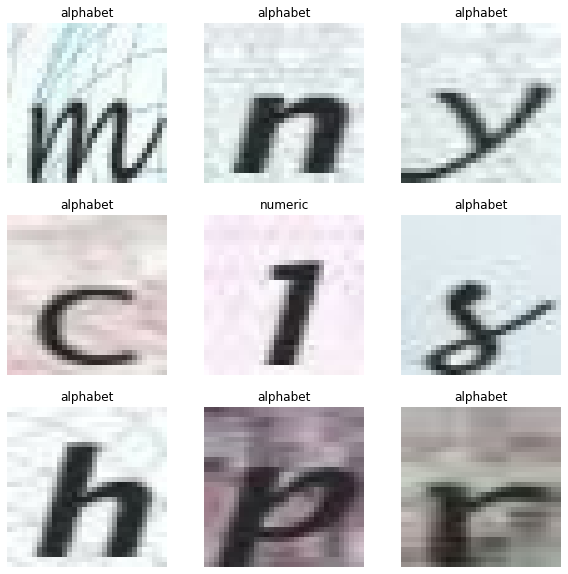

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(3, 12):
        ax = plt.subplot(3, 3, i - 2)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [4]:
    def preprocess_image(images_path, type='jpg'):

        images_list = glob.glob(f'{images_path}/*.{type}')
        images = np.zeros([len(images_list), 32, 32, 3])
        for i in range(len(images_list)):
            image = cv2.imread(images_list[i])
            #print(image.shape)
            if image.shape != (32, 32, 3):
                #print('kir')
                image = cv2.resize(image, (32, 32))
                cv2.imshow('nothing',image)
            image_array = np.asarray(image)
            #print(image_array.shape)
            images[i, :, :, :] = image_array

        return images

In [ ]:
tf.keras.models.load_model('tmp/models/checkpoint_alpha=0.01_bn_aug(rc)_do(1)')

In [5]:
images = preprocess_image('../Datasets/work/fashion/valid/numeric/')
#Image.open('../Datasets/work/fashion/valid/numeric/0_26.jpg').size
images.shape

(415, 32, 32, 3)

In [6]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential() 
    data_augmentation.add(RandomContrast(0.3))
    #data_augmentation.add(RandomZoom((0, 0.)))
    
    
    return data_augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


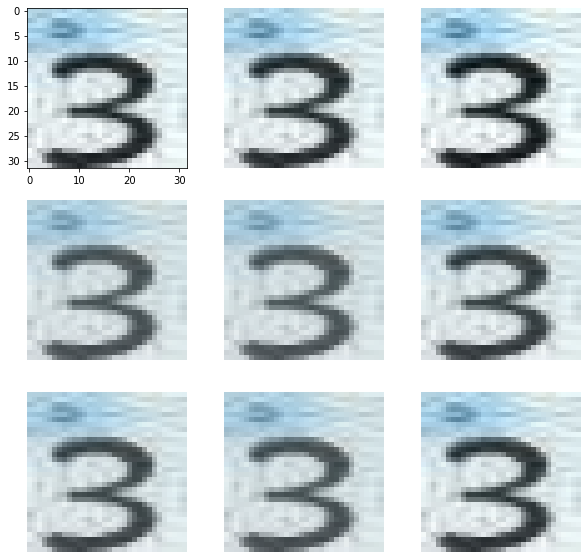

In [7]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    
    first_image = image[0]
    #print(type(first_image))
    plt.subplot(3, 3, 1)
    plt.imshow(first_image/255)
    for i in range(8):
        ax = plt.subplot(3, 3, i + 2)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [8]:
def block_c(x, power, last_filters):
    batch, input_height, input_width, input_channels = x.shape
    #print(f'input_c:{x.shape}')
    x = tkl.Conv2D(power*input_channels, (1, 1), padding='same')(x)
    #x = tkl.Dropout(0.1)(x)
    #print(f'1st_conv_c:{x.shape}')
    x = tkl.BatchNormalization(axis=3)(x, training=True)
    x = tkl.ReLU(max_value=6)(x)
    x = tkl.DepthwiseConv2D((3, 3), strides=(2, 2),padding='same')(x)
    #x = tkl.Dropout(0.1)(x)
    #print(f'1st_depth_c:{x.shape}')
    #x = tkl.BatchNormalization(axis=3)(x, training=True)
    x = tkl.ReLU(max_value=6)(x)
    x = tkl.Conv2D(last_filters, (1, 1), padding='same')(x)
    #x = tkl.Dropout(0.3)(x)
    x = tkl.BatchNormalization(axis=3)(x, training=True)
    #print(f'2nd_conv_c:{x.shape}')
    return x

In [9]:
def block_b(x, power, last_filters):
    batch, input_height, input_width, input_channels = x.shape
    #print(f'input_b:{x.shape}')
    
    x = tkl.Conv2D(power*input_channels, (1, 1), padding='same')(x)
    #x = tkl.Dropout(0.2)(x)
    #x = tkl.Dropout(0.1)(x)
    #print(f'1st_conv_b:{x.shape}')
    x = tkl.BatchNormalization(axis=3)(x, training=True)
    x = tkl.ReLU(max_value=6)(x)
    x = tkl.DepthwiseConv2D((3, 3), padding='same')(x)
    #x = tkl.Dropout(0.1)(x)
    x = tkl.BatchNormalization(axis=3)(x, training=True)
    #print(f'1st_depth_b:{x.shape}')
    x = tkl.ReLU(max_value=6)(x)
    x = tkl.Conv2D(last_filters, (1, 1), padding='same')(x)
    x = tkl.Dropout(0.3)(x)
    x = tkl.BatchNormalization(axis=3)(x, training=True)
    #print(f'2nd_conv_b:{x.shape}')
    return x

In [10]:
def block_a(x, power, last_filters):
    batch, input_height, input_width, input_channels = x.shape
    x = tkl.BatchNormalization(axis=3)(x, training=True)
    input_x = x
    #print(f'input_a:{x.shape}')
    x = tkl.Conv2D(power*input_channels, (1, 1), padding='same')(x)
    #x = tkl.Dropout(0.1)(x)
    x = tkl.BatchNormalization(axis=3)(x, training=True)
    #print(f'1st_conv_a:{x.shape}')
    x = tkl.ReLU(max_value=6)(x)
    x = tkl.DepthwiseConv2D((3, 3), padding='same')(x)
    #x = tkl.Dropout(0.1)(x)
    x = tkl.BatchNormalization(axis=3)(x, training=True)
    #print(f'1st_depth_a:{x.shape}')
    x = tkl.ReLU(max_value=6)(x)
    x = tkl.Conv2D(last_filters, (1, 1), padding='same')(x)
    #x = tkl.Dropout(0.3)(x)
    
    x = tkl.BatchNormalization(axis=3)(x, training=True)
    #print(f'2nd_conv_a:{x.shape}')
    x = tkl.Add()([x, input_x])
    #print(f'add_a:{x.shape}')
    return x

In [11]:
def conv_model(input_shape=(32, 32, 3)):
    x_input = Input(shape=input_shape)
    #print(f'input:{x_input.shape}')
    x = data_augmenter()(x_input)
    x = tkl.Conv2D(8, (3, 3), strides=(2, 2),padding='same')(x)
    x = tkl.BatchNormalization(axis=3)(x, training=True)
    #print(f'1st_conv:{x.shape}')
    x = block_c(x, 1, 8)
    x = block_c(x, 2, 16)
    x = block_a(x, 2, 16)
    x = block_c(x, 2, 24)
    x = block_a(x, 2, 24)
    x = block_b(x, 2, 32)
    x = tkl.Flatten()(x)
    x = tkl.Dense(1, activation='sigmoid', kernel_initializer=glorot_uniform(seed=0))(x)
    model = Model(inputs=x_input, outputs=x)
    return model

In [12]:
model = conv_model(input_shape = (32, 32, 3))
#print(model.summary())

In [13]:
def equal_error_rate(y_true, y_pred):
    n_imp = tf.math.count_nonzero(tf.equal(y_true, 0), dtype=tf.float32) + tf.constant(K.epsilon())
    n_gen = tf.math.count_nonzero(tf.equal(y_true, 1), dtype=tf.float32) + tf.constant(K.epsilon())

    scores_imp = tf.boolean_mask(y_pred, tf.equal(y_true, 0))
    scores_gen = tf.boolean_mask(y_pred, tf.equal(y_true, 1))

    loop_vars = (tf.constant(0.0), tf.constant(1.0), tf.constant(0.0))
    cond = lambda t, fpr, fnr: tf.greater_equal(fpr, fnr)
    body = lambda t, fpr, fnr: (
        t + 0.001,
        tf.divide(tf.math.count_nonzero(tf.greater_equal(scores_imp, t), dtype=tf.float32), n_imp),
        tf.divide(tf.math.count_nonzero(tf.less(scores_gen, t), dtype=tf.float32), n_gen)
    )
    t, fpr, fnr = tf.while_loop(cond, body, loop_vars, back_prop=False)
    eer = (fpr + fnr) / 2

    return eer

In [14]:
base_learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

c:\Users\mmagb\anaconda3\envs\tf-gpu\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
initial_epochs = 25
checkpoint_filepath = 'tmp/models/checkpoint_alpha=0.01_bn_aug(rc)_do(1)'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor= 'val_accuracy',mode='max', save_best_only=True)
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, callbacks=model_checkpoint_callback)

Epoch 1/25


c:\Users\mmagb\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


157/157 [==============================] - 347s 2s/step - loss: 0.0523 - accuracy: 0.9806 - val_loss: 0.4010 - val_accuracy: 0.9241
Epoch 2/25
157/157 [==============================] - 22s 136ms/step - loss: 0.0042 - accuracy: 0.9987 - val_loss: 0.4943 - val_accuracy: 0.9434
Epoch 3/25
157/157 [==============================] - 14s 84ms/step - loss: 0.0037 - accuracy: 0.9992 - val_loss: 0.4598 - val_accuracy: 0.9373
Epoch 4/25
157/157 [==============================] - 10s 60ms/step - loss: 0.0032 - accuracy: 0.9990 - val_loss: 0.4525 - val_accuracy: 0.9386
Epoch 5/25
157/157 [==============================] - 10s 62ms/step - loss: 0.0034 - accuracy: 0.9990 - val_loss: 0.3000 - val_accuracy: 0.9373
Epoch 6/25
157/157 [==============================] - 10s 63ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.3522 - val_accuracy: 0.9181
Epoch 7/25
157/157 [==============================] - 10s 60ms/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.4982 - val_accuracy: 0.9181
Epo

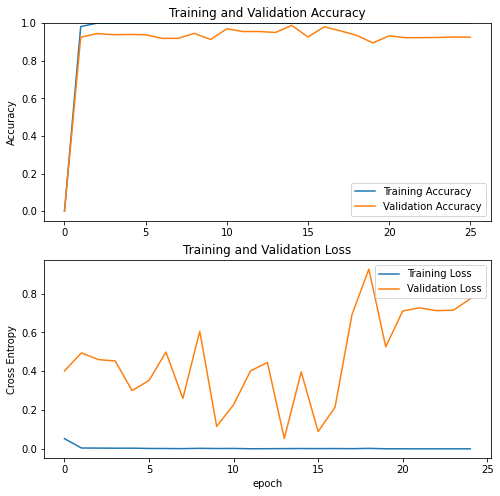

In [16]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
eer = [0.] + history.history['equal_error_rate']
val_eer = [0.] + history.history['val_equal_error_rate']

plt.figure(figsize=(8, 8))
plt.plot(eer, label='Training Equal Error Rate')
plt.plot(val_eer, label='Validation Equal Error Rate')
plt.legend(loc='lower right')
plt.ylabel('Equal Error Rate')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Equal Error Rate')
plt.show()

In [17]:
max(history.history['val_accuracy'])

0.9867469668388367

In [18]:
class_names

['alphabet', 'numeric']

In [8]:
checkpoint_filepath = 'tmp/models/checkpoint_alpha=0.01_bn_aug(rc)_do(1)'
model= tf.keras.models.load_model(checkpoint_filepath)

In [6]:
tf.keras.models.save_model(model,'tmp/models/checkpoint_alpha=0.01_bn_aug(rc)_do(2).h5',overwrite=False,save_format='h5')

[TIP] Next time specify overwrite=True!


In [4]:
numpy_images = np.zeros([830, 32, 32, 3])
numpy_labels = np.zeros([830, 1])
k = 0

for images, labels in validation_dataset.take(np.floor(830/BATCH_SIZE) + 1):
    images_n = images.numpy()
    labels_n = labels.numpy()
    for i in range(labels_n.shape[0]):
        numpy_labels[i + k*BATCH_SIZE] = labels_n[i]
        numpy_images[i + k*BATCH_SIZE, :, :, :] = images_n[i]
    k = k + 1

numpy_labels_pred = model.predict(numpy_images)

In [7]:
numpy_images = np.zeros([19980, 32, 32, 3])
numpy_labels = np.zeros([19980, 1])
k = 0

for images, labels in validation_dataset.take(np.floor(19980/BATCH_SIZE) + 1):
    images_n = images.numpy()
    labels_n = labels.numpy()
    for i in range(labels_n.shape[0]):
        numpy_labels[i + k*BATCH_SIZE] = labels_n[i]
        numpy_images[i + k*BATCH_SIZE, :, :, :] = images_n[i]
    k = k + 1

numpy_labels_pred = model.predict(numpy_images)

In [5]:
def compute_eer(numpy_labels, numpy_labels_pred, positive_label=1):



    # all fpr, tpr, fnr, fnr, threshold are lists (in the format of np.array)
    fpr, tpr, threshold = sklearn.metrics.roc_curve(numpy_labels, numpy_labels_pred, pos_label=positive_label)
    fnr = 1 - tpr

    # the threshold of fnr == fpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]

    # theoretically eer from fpr and eer from fnr should be identical but they can be slightly differ in reality
    eer_1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    eer_2 = fnr[np.nanargmin(np.absolute((fnr - fpr)))]

    # return the mean of eer from fpr and from fnr
    eer = kbe.sum(eer_1/2 + eer_2/2)
    #eer = kbe.floatx()
    return eer

In [8]:
compute_eer(numpy_labels, numpy_labels_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.002201497017972203>

In [30]:
equal_error_rate(numpy_labels, numpy_labels_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.006024096>

: 